# Step #1 Load the Data

In [2]:
# A tutorial for this file is available at www.relataly.com
# Tested with Python 3.8.8, Matplotlib 3.5, Scikit-learn 0.24.1, Seaborn 0.11.1, numpy 1.19.5

import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from pandas.api.types import is_string_dtype, is_numeric_dtype 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score

# Source: 
# https://www.kaggle.com/datasets/lepchenkov/usedcarscatalog

# Load train and test datasets
path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/car_prices/train.csv"
df = pd.read_csv(path)

# Create a categorical target variable from price_usd
df['price_usd_class'] = ['low' if x < 2100 else 'middle' if (x >= 2100 and x <= 8990) else 'high' for x in df['price_usd']]

# Set the targetname for Classification
df = df.drop(columns=['price_usd'])
target_name = 'price_usd_class'

df.head()

# Step #2 Univerariate Data Analysis 

[Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '10 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)'),
 Text(0, 0, '0 (0.0%)')]

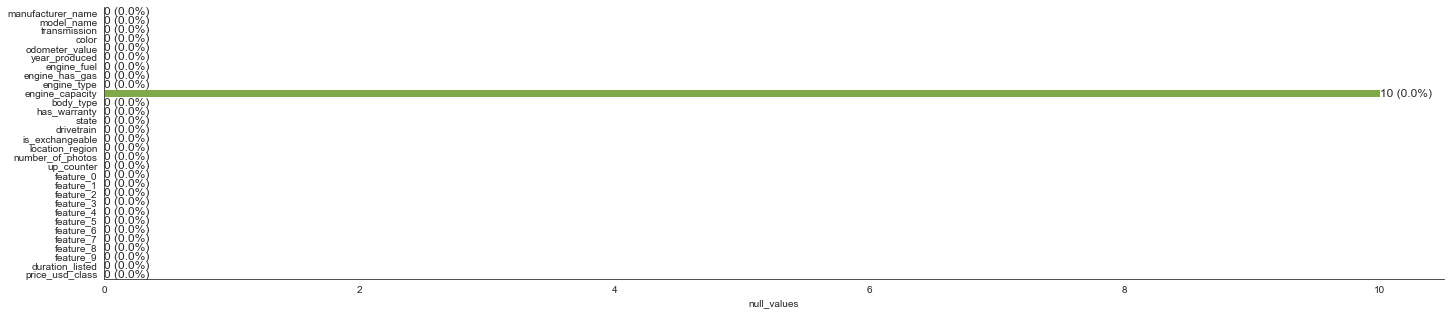

In [4]:
# Check for Missing Values
null_values = pd.DataFrame(df.isna().sum())
null_values.columns=['null_values']
plt.subplots(figsize=(24, 5))
ax = sns.barplot(data=pd.DataFrame(data=null_values), x='null_values', y=null_values.index)
pct_values = ['{:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_values['null_values'])]
ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

In [5]:
# Identify columns with many missing values
df = df.drop(columns=['engine_capacity']) # alternatively you can use .fillna(0) to replace the na values with 0 
df.head(2)

# Create a dataset with all features. This will allow us latere to train a full feature model to which we can compare our subset feature model
df_all = df.copy()

In [24]:
# Desccribe function
print(df.columns)
df.describe()

Index(['manufacturer_name', 'model_name', 'transmission', 'color',
       'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
       'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain',
       'is_exchangeable', 'location_region', 'number_of_photos', 'up_counter',
       'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'duration_listed', 'price_usd_class'],
      dtype='object')


,odometer_value,year_produced,number_of_photos,up_counter,duration_listed
count,38531.000000,38531.000000,38531.000000,38531.000000,38531.000000
mean,248864.638447,2002.943734,9.649062,16.306091,80.577249
std,136072.376530,8.065731,6.093217,43.286933,112.826569
min,0.000000,1942.000000,1.000000,1.000000,0.000000
25%,158000.000000,1998.000000,5.000000,2.000000,23.000000
50%,250000.000000,2003.000000,8.000000,5.000000,59.000000
75%,325000.000000,2009.000000,12.000000,16.000000,91.000000
max,1000000.000000,2019.000000,86.000000,1861.000000,2232.000000


categorical features: 10


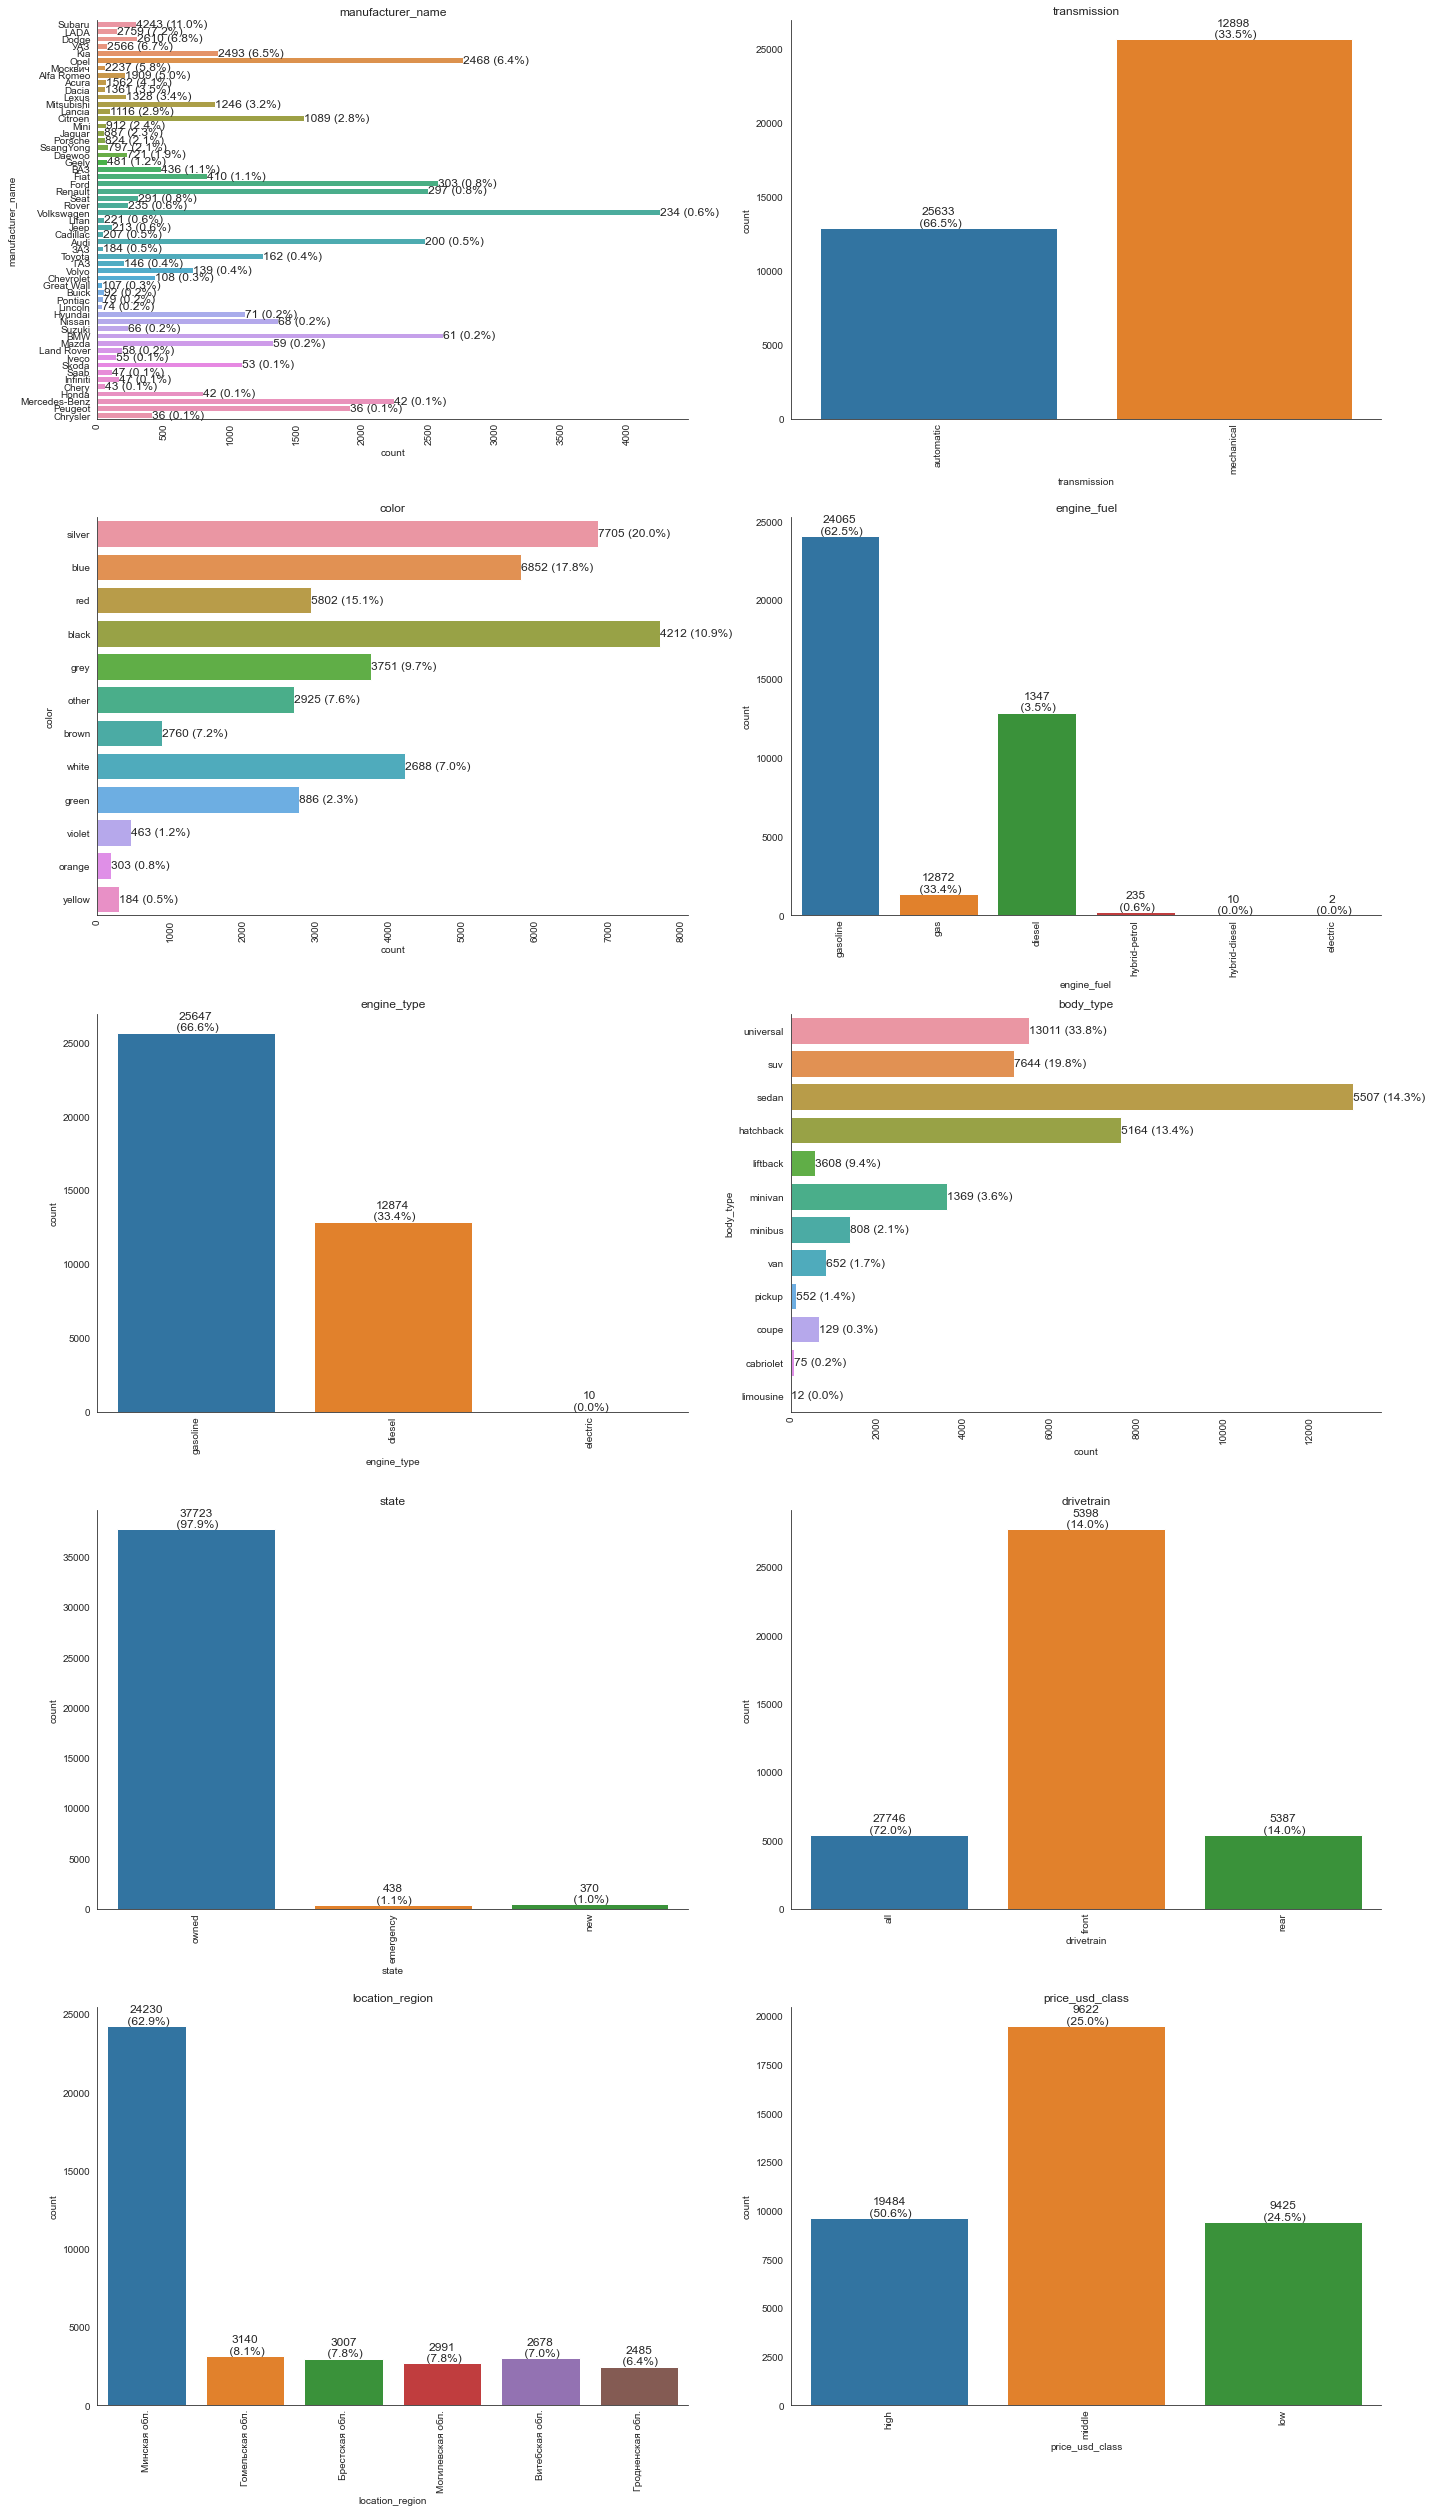

In [10]:
# Barplots to visualize the distribution of categorical variables
f_list = [x for x in df.columns if is_string_dtype(df[x])]
f_list.remove('model_name')
f_list_len = len(f_list)

print(f'categorical features: {f_list_len}')

# Adjust plotsize based on the number of features
ncols = 2
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*7))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        if (df[column_name].nunique()) > 10:
            sns.countplot(data=df, y=column_name, ax = ax)
            pct_values = ['{:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(df[column_name].value_counts())]
        else:
            sns.countplot(data=df, x=column_name, ax = ax)
            ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)
            pct_values = ['{:g}'.format(elm) + '\n ({:.1%})'.format(elm/len(df)) for elm in list(df[column_name].value_counts())]
        ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)
        ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)
        ax.set_title(column_name)
        fig.tight_layout()

In [26]:
# Drop features with low variety
df = df.drop(columns=['state', 'location_region'])
df.head(2)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,body_type,...,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd_class
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,universal,...,True,True,False,True,False,True,True,True,16,high
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,universal,...,False,False,True,True,False,False,False,True,83,middle


# Step #3 Bivariate Analysis

manufacturer_name
model_name
transmission
color
odometer_value
year_produced
engine_fuel
engine_has_gas
engine_type
body_type
has_warranty
state
drivetrain
is_exchangeable
location_region
number_of_photos
up_counter
feature_0
feature_1
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
duration_listed
price_usd_class


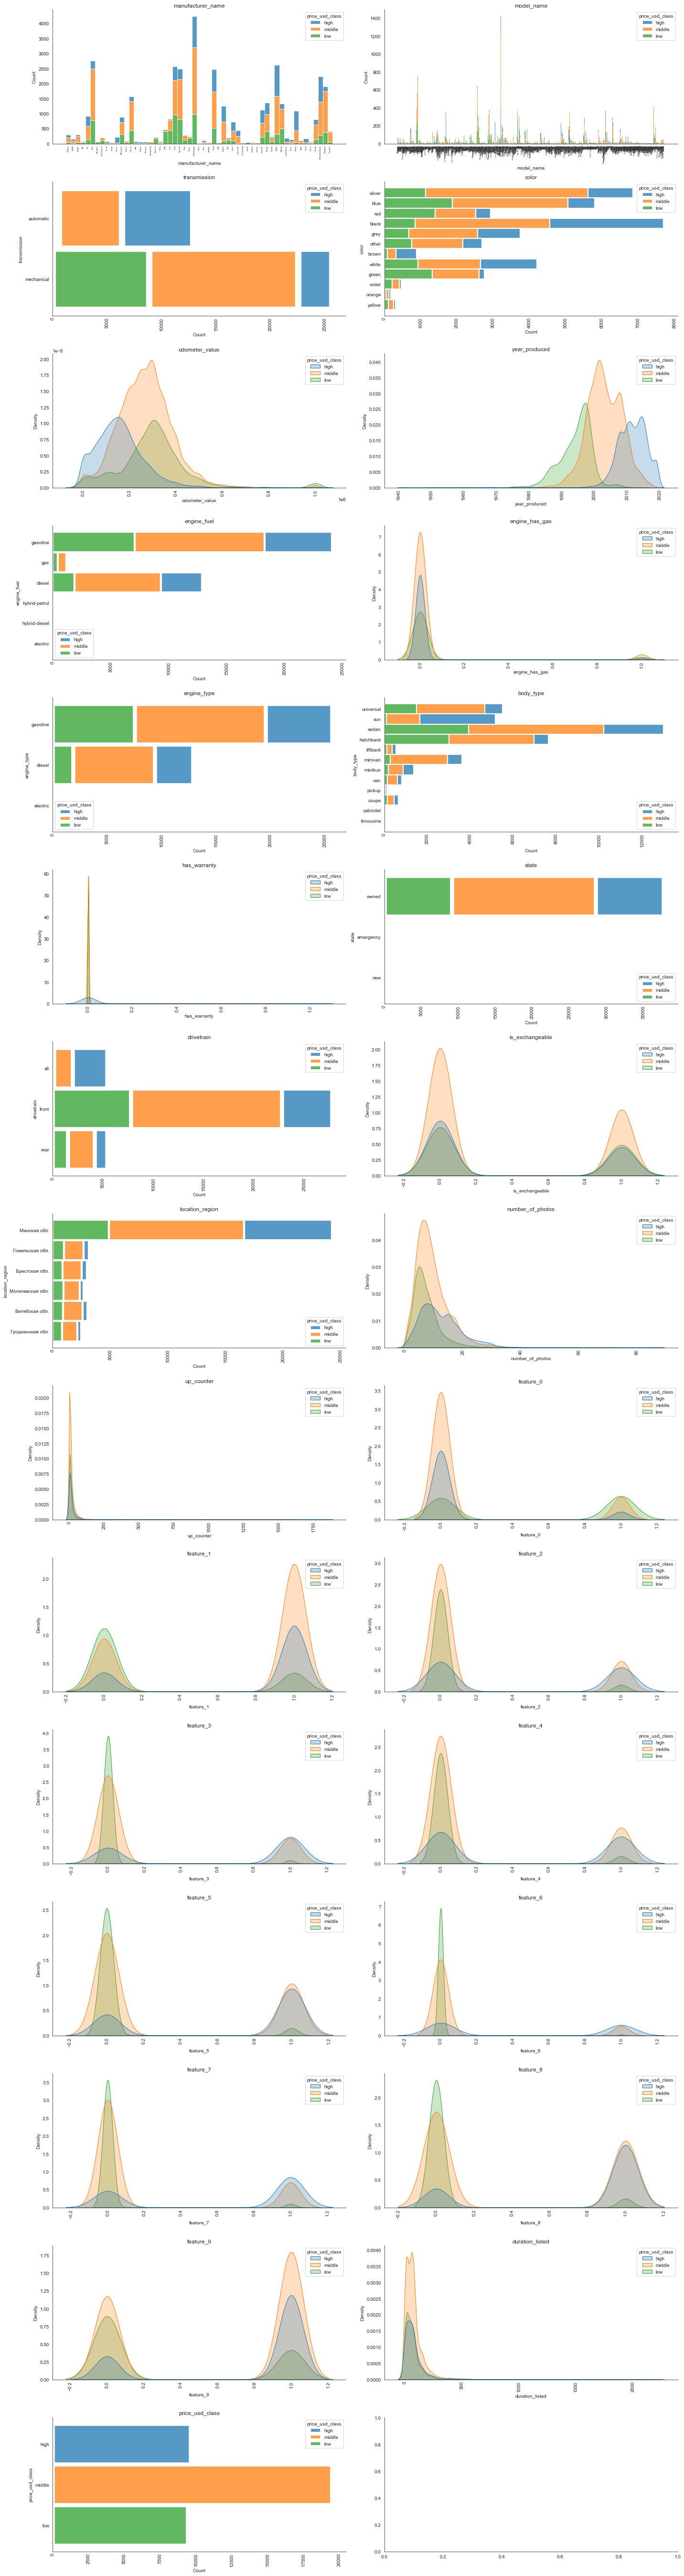

In [11]:
# Vizualising Distributions
f_list = [x for x in df.columns]
f_list_len = len(f_list)

# Adjust plotsize based on the number of features
ncols = 2
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        print(column_name)
        # if the variable is numeric draw a kernel density estimate plot
        if (is_numeric_dtype(df[column_name])):
            sns.kdeplot(data=df, hue=target_name, x=column_name, fill=True, ax = ax)
            labelsize = 10
        # If a variable has more than 8 unique values draw a scatterplot, else draw a violinplot 
        else:
            if df[column_name].nunique() > 20:
                sns.histplot(hue=target_name, x=column_name, data=df, multiple = 'stack', ax = ax)
                labelsize = 4
            # Categorical Variables with more than 20 characteristics
            else:
                sns.histplot(hue=target_name, y=column_name, data=df, multiple = 'stack', ax = ax)
                labelsize = 10
        ax.tick_params(axis="x", rotation=90, labelsize=labelsize, length=0)
        ax.set_title(column_name)
    fig.tight_layout()

In [ ]:
# Drop features with low variety
df = df.drop(columns=['is_exchangeable', 'engine_has_gas', 'number_of_photos'])
df.head(2)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,body_type,has_warranty,...,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd_class
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,gasoline,universal,False,...,True,True,False,True,False,True,True,True,16,high
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,gasoline,universal,False,...,False,False,True,True,False,False,False,True,83,middle


# Step #4 Correlation Analysis

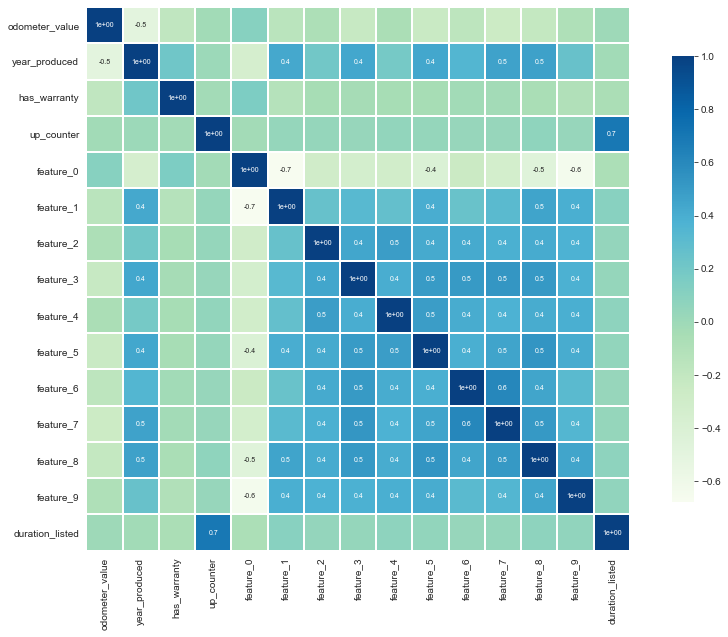

In [ ]:
# Correlation Analysis: Heatmap facilitates the identification of highly correlated explanatory variables and reduce collinearity
plt.figure(figsize = (15,10))
plt.yticks(rotation=0)
correlation = df.corr()
ax =  sns.heatmap(correlation, cmap='GnBu',square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7})
sns.set(font_scale=0.8)
for f in ax.texts:
    if float(f.get_text())>=0.4:
        f.set_text(f.get_text()) #if the value is greater than 0.4 then I set the text 
    elif float(f.get_text())<=-0.4:
        f.set_text(f.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        f.set_text("") # if not it sets an empty text

In [ ]:
# Drop one of the high correlated feature pairs
df_reduced_ = df.drop(columns=['duration_listed', 'feature_3', 'feature_5', 'feature_8', 'has_warranty', 'up_counter', 'duration_listed'])

# Drop features that are low correlated with the target variable
df_subset = df_reduced_.drop(columns=['feature_0'])

# Show the subset and the all df features
df_subset.head(2)
sub_df_feature_num = len(df_subset.columns)
all_df_feature_num = len(df_all.columns)
print(list(df_subset.columns))
print(list(df_all.columns))
print(f'features in the subset: {sub_df_feature_num}')
print(f'features in the full dataset: {all_df_feature_num}')

['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 'engine_type', 'body_type', 'drivetrain', 'feature_1', 'feature_2', 'feature_4', 'feature_6', 'feature_7', 'feature_9', 'price_usd_class']
['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain', 'is_exchangeable', 'location_region', 'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'duration_listed', 'price_usd_class']
features in the subset: 17
features in the full dataset: 29


# Step #5 Preprocessing

In [ ]:
def splitting(df):

    # Create a list of categorical variables that we want to encode
    categorical_list = [x for x in df.columns if is_string_dtype(df[x])]
    le = LabelEncoder()
    # Apply the encoding to the categorical variables
    # Since, the apply() function has no inplace argument,  we must use the following syntax to transform the df
    df[categorical_list] = df[categorical_list].apply(LabelEncoder().fit_transform)
    
    # # Separate labels from training data
    X = df.drop(columns=[target_name])
    y = df[target_name] #Prediction label

    # Split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train and test shapes')
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# Step #6 Model Training

In [ ]:
def train_model(X, y, X_train, y_train):
    estimator = DecisionTreeClassifier()
    scores = cross_val_score(estimator, X, y, cv=10)
    estimator.fit(X_train, y_train)
    return scores, estimator

# Train the model with the subset of selected features
X_sub, y_sub, X_train_sub, X_test_sub, y_train_sub, y_test_sub = splitting(df_subset)
scores_sub, estimator_sub = train_model(X_sub, y_sub, X_train_sub, y_train_sub)
    
# Train the model with all features
X_all, y_all, X_train_all, X_test_all, y_train_all, y_test_all = splitting(df_all)
scores_all, estimator_all = train_model(X_all, y_all, X_train_all, y_train_all)

train and test shapes
(26971, 16) (26971,)
(11560, 16) (11560,)
train and test shapes
(26971, 28) (26971,)
(11560, 28) (11560,)


# Step #7 Model Comparison - Subset vs All

       price_usd_class  PredictedPrice
5309                 2               2
15125                2               2
23473                2               2
28812                2               2
7903                 1               2
       price_usd_class  PredictedPrice
5309                 2               2
15125                2               2
23473                2               2
28812                2               2
7903                 1               2


Text(0.5, 1.0, 'Cross validation scores of the full dataset model')

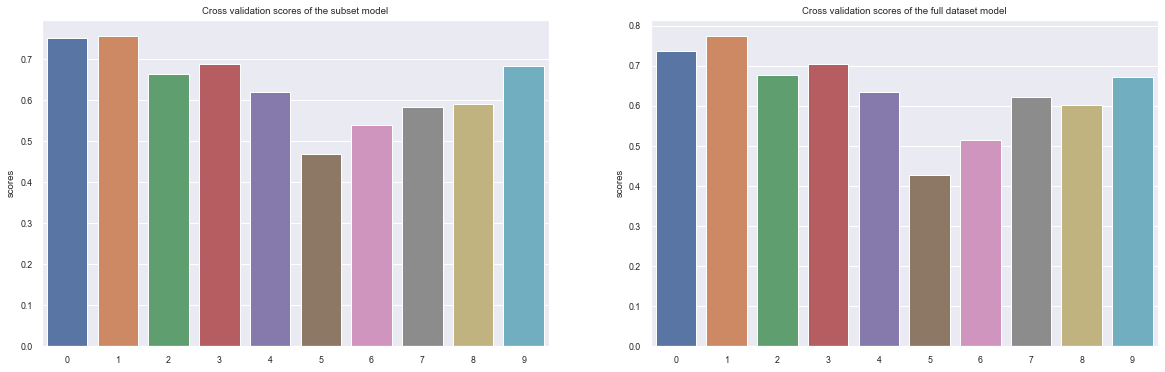

In [ ]:
def create_metrics(scores, estimator, X_test, y_test):
    scores_df = pd.DataFrame({'scores':scores})

    y_pred = estimator.predict(X_test)
    y_df = pd.DataFrame(y_test)
    y_df['PredictedPrice']=y_pred
    print(y_df.head())
    
    # Feature Importance
    r = permutation_importance(estimator, X_test, y_test, n_repeats=30, random_state=0)
    data_im = pd.DataFrame(r.importances_mean, columns=['feature_permuation_score'])
    data_im['feature_names'] = X_test.columns
    data_im = data_im.sort_values('feature_permuation_score', ascending=False)
    
    return scores_df, data_im

scores_df_sub, data_im_sub = create_metrics(scores_sub, estimator_sub, X_test_sub, y_test_sub)
scores_df_all, data_im_all = create_metrics(scores_all, estimator_all, X_test_all, y_test_all)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=scores_df_sub, y='scores', x =scores_df_sub.index, ax=axs[0])
axs[0].set_title('Cross validation scores of the subset model')
sns.barplot(data=scores_df_all, y='scores', x =scores_df_all.index, ax=axs[1])
axs[1].set_title('Cross validation scores of the full dataset model')

In [ ]:
# Evaluate model performance


def evaluate_results(model, X_test, y_test, estimator_name):
    
    # Predict class labels using the learner function
    y_pred = model.predict(X_test)
    model_score = score(y_pred, y_test, average='macro')
    results_df = pd.DataFrame().append({'model_name': estimator_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, 
                                       ignore_index=True)
    
    return results_df

results_df_sub = evaluate_results(estimator_sub, X_test_sub, y_test_sub, 'model_sub')
results_df_all = evaluate_results(estimator_all, X_test_all, y_test_all, 'model_all')
results_df = results_df_sub.append(results_df_all)

  model_name  f1_score  precision    recall
0  model_sub  0.811835   0.809806  0.810808
0  model_all  0.804615   0.803791  0.804199


<AxesSubplot:xlabel='Value', ylabel='Model_Name'>

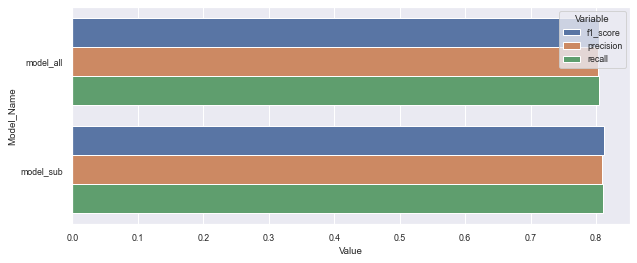

In [ ]:
print(results_df)

fig, ax = plt.subplots(figsize=(10, 4))
tidy = results_df.sort_values('model_name').melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, linewidth=1, edgecolor="w")

Text(0.5, 1.0, 'Feature importance scores of the full dataset model')

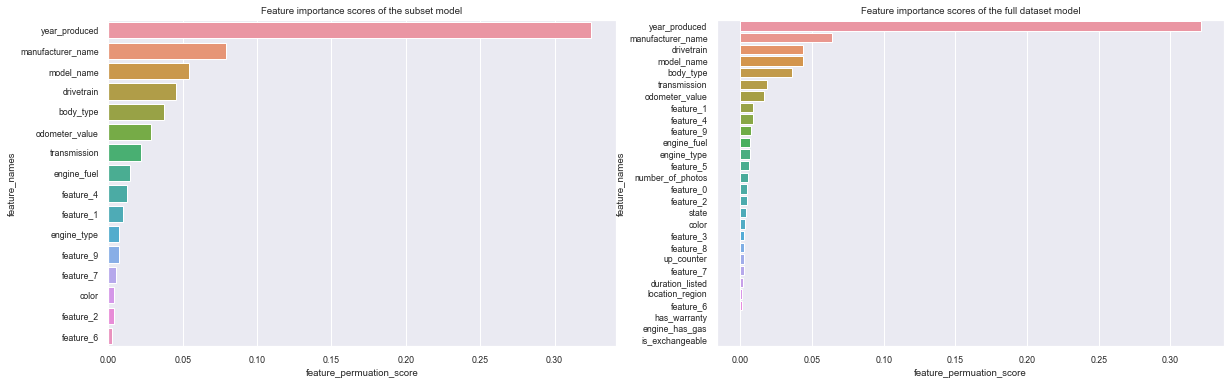

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(data=data_im_sub, y='feature_names', x="feature_permuation_score", ax=axs[0])
axs[0].set_title("Feature importance scores of the subset model")
sns.barplot(data=data_im_all, y='feature_names', x="feature_permuation_score", ax=axs[1])
axs[1].set_title("Feature importance scores of the full dataset model")